<a href="https://colab.research.google.com/github/aravindskumar98/AppliedDL/blob/main/Eigenfaces_Fisherfaces_SRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import matplotlib library
import matplotlib.pyplot as plt
 
# Import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from matplotlib.ticker import FixedLocator
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import SparseCoder
 
import numpy as np
import pandas as pd

In [ ]:
import scipy.io
## Import data
mat = scipy.io.loadmat('/content/drive/MyDrive/YaleB_32x32.mat')

##obtain input pixels and output
fea = np.array(mat['fea'])
gnd = np.array(mat['gnd'])

##Data preprocessing

## join the input and output into one numpy array
data = np.concatenate((fea, gnd), axis=1)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


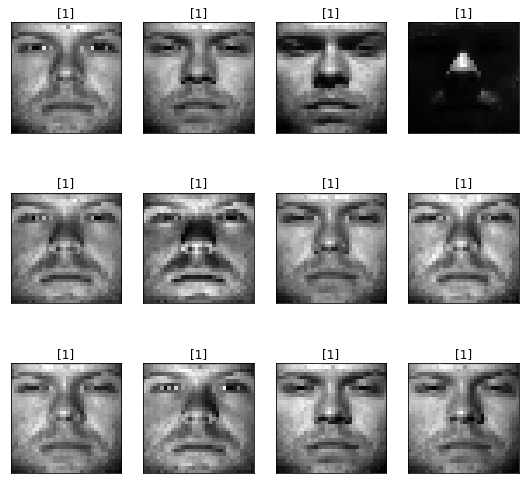

In [ ]:

def plot_gallery(fea, gnd, h = 32, w = 32, n_row = 3, n_col = 4):
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(fea[i].reshape(h, w).T, cmap = plt.cm.gray)
        plt.title(gnd[i], size = 12)
        plt.xticks(())
        plt.yticks(())
 
plot_gallery(fea, gnd, 32,32)

# Eigen Faces

### Note: Since the smallest euclidean metric is being asked for, this is effectively the same as using a 1-NN model with Euclidean distance metric

In [ ]:
data_faces = np.split(data, np.where(np.diff(data[:,-1]))[0]+1)
m_set = [10,20,30,40,50]
score_m_eigen = []

In [ ]:
for m in m_set:
  trainX = []
  trainY = []
  testX = []
  testY = []
  ## iterate through each person and sample m instances
  for person in data_faces:
    df = pd.DataFrame(person)
    training_data = df.sample(n = m, random_state=1) #23
    testing_data = df.drop(training_data.index)
    for i in range(len(training_data)):
      trainX.append(np.array(training_data.iloc[i,:])[:-1])
      trainY.append(np.array(training_data.iloc[i,:])[-1])
    for i in range(len(testing_data)):
      testX.append(np.array(testing_data.iloc[i,:])[:-1])
      testY.append(np.array(testing_data.iloc[i,:])[-1])

  X_train = np.array(trainX)
  y_train = np.array(trainY)
  X_test = np.array(testX)
  y_test = np.array(testY)
  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)

  h,w = 32,32
  n_components = 150
  
  # t0 = time()
  pca = PCA(n_components = n_components, svd_solver ='randomized',
            whiten = True).fit(X_train)
  # print("done in % 0.3fs" % (time() - t0))
  
  eigenfaces = pca.components_.reshape((n_components, h, w))
  
 #"Projecting the input data on the eigenfaces orthonormal basis"
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  # print(X_train_pca.shape, X_test_pca.shape, y_test.shape, y_train.shape)

  pwr = 2
  k = 1

  ## Since the smallest euclidean metric is being asked for, this is effectively the same as using a 1-NN model with Euclidean distance metric.
  nbrs = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
  ## fitting it to the training data
  nbrs.fit(X_train_pca, y_train)
  ## prediction of the KNN model
  pred_out = nbrs.predict(X_test_pca)

  ## accuracy of the model
  accuracy = metrics.accuracy_score(y_test, pred_out)
  error_rate = 1 - accuracy
  print(f'k = {k}, m = {m}, pwr = {pwr}, error_rate= {error_rate:.3f}')

  score_m_eigen.append(100 - accuracy*100)

k = 1, m = 10, pwr = 2, error_rate= 0.175
k = 1, m = 20, pwr = 2, error_rate= 0.154
k = 1, m = 30, pwr = 2, error_rate= 0.085
k = 1, m = 40, pwr = 2, error_rate= 0.045
k = 1, m = 50, pwr = 2, error_rate= 0.004


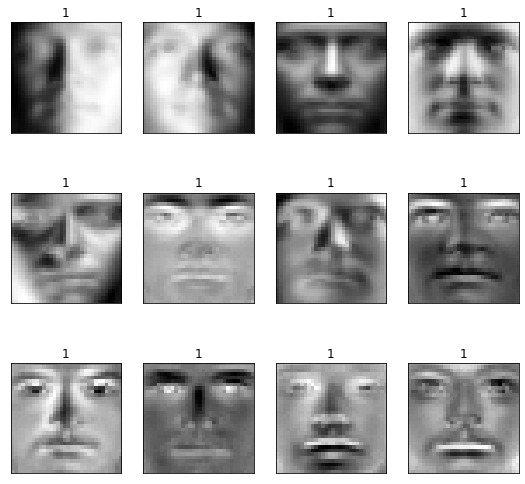

In [ ]:
plot_gallery(eigenfaces, y_train, 32,32)

# Pixel Intensity SVM

In [ ]:
score_m_svm = []
for m in m_set:
  trainX = []
  trainY = []
  testX = []
  testY = []
  ## iterate through each person and sample m instances
  for person in data_faces:
    df = pd.DataFrame(person)
    training_data = df.sample(n = m, random_state=1)
    testing_data = df.drop(training_data.index)
    for i in range(len(training_data)):
      trainX.append(np.array(training_data.iloc[i,:])[:-1])
      trainY.append(np.array(training_data.iloc[i,:])[-1])
    for i in range(len(testing_data)):
      testX.append(np.array(testing_data.iloc[i,:])[:-1])
      testY.append(np.array(testing_data.iloc[i,:])[-1])

  X_train = np.array(trainX)
  y_train = np.array(trainY)
  X_test = np.array(testX)
  y_test = np.array(testY)
  scaler = StandardScaler()
  print("")
  print("")
  print(f"k = {k} and m = {m}")

  # "Fitting the classifier to the training set"
  clf = SVC(kernel ='linear')

  clf = clf.fit(X_train, y_train)
  
 # "Predicting people's names on the test set"
  y_pred = clf.predict(X_test)

  # print classification results
  accuracy_svm = metrics.accuracy_score(y_test, y_pred)
  error_rate = 1 -accuracy_svm
  print(f"error_rate :  {error_rate:.2f}")
  score_m_svm.append(100*error_rate)




k = 1 and m = 10
error_rate :  0.21


k = 1 and m = 20
error_rate :  0.13


k = 1 and m = 30
error_rate :  0.06


k = 1 and m = 40
error_rate :  0.04


k = 1 and m = 50
error_rate :  0.03


# LDA

In [ ]:
score_m_lda = []
for m in m_set:
  trainX = []
  trainY = []
  testX = []
  testY = []
  ## iterate through each person and sample m instances
  for person in data_faces:
    df = pd.DataFrame(person)
    training_data = df.sample(n = m, random_state=1)
    testing_data = df.drop(training_data.index)
    for i in range(len(training_data)):
      trainX.append(np.array(training_data.iloc[i,:])[:-1])
      trainY.append(np.array(training_data.iloc[i,:])[-1])
    for i in range(len(testing_data)):
      testX.append(np.array(testing_data.iloc[i,:])[:-1])
      testY.append(np.array(testing_data.iloc[i,:])[-1])

  X_train = np.array(trainX)
  y_train = np.array(trainY)
  X_test = np.array(testX)
  y_test = np.array(testY)
  scaler = StandardScaler()
  print("")
  print(f"k = {k} and m = {m}")

  # "Fitting the classifier to the training set"
  lda = LinearDiscriminantAnalysis()
  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)

  lda.fit(X_train, y_train)
  yHat = lda.predict(X_test)
  #Compute classification error
  outVal = metrics.accuracy_score(y_test, yHat)
  error_rate = 1 - outVal
  print(f"error_rate :  {error_rate:.4f}")
  score_m_lda.append(100*error_rate)


k = 1 and m = 10
error_rate :  0.1917

k = 1 and m = 20
error_rate :  0.1475

k = 1 and m = 30
error_rate :  0.2323

k = 1 and m = 40
error_rate :  0.0291

k = 1 and m = 50
error_rate :  0.0039


# SRC

In [ ]:
## This function returns the face with best fit
def classify_SRC(D, y, x, train_size, nb_classes):

    res_tab = np.zeros(nb_classes)
    
    for i in range(nb_classes): 
        x_class = x[train_size * i:train_size * (i + 1)]
        D_instances = D[:, train_size * i:train_size * (i + 1)]
        
        ## Calculate the residual for all the classes 
        res = y - D_instances.dot(x_class) 
        res_tab[i] = np.linalg.norm(res, ord = 2) 
        
    return np.argmin(res_tab) + 1

In [ ]:
ms = [10,20,30,40,50]

score_m_src = []
for m in ms:
  trainX = []
  trainY = []
  testX = []
  testY = []
  ## iterate through each person and sample m instances
  for person in data_faces:
    df = pd.DataFrame(person)
    training_data = df.sample(n = m, random_state=2)
    testing_data = df.drop(training_data.index)
    for i in range(len(training_data)):
      trainX.append(np.array(training_data.iloc[i,:])[:-1])
      trainY.append(np.array(training_data.iloc[i,:])[-1])
    for i in range(len(testing_data)):
      testX.append(np.array(testing_data.iloc[i,:])[:-1])
      testY.append(np.array(testing_data.iloc[i,:])[-1])

  X_train = np.array(trainX)
  y_train = np.array(trainY)
  X_test = np.array(testX)
  y_test = np.array(testY)

  coder = SparseCoder(dictionary=X_train.astype(np.float32))
  x_out = coder.transform(X_test.astype(np.float32))
  ans = []
  for i in range(len(x_out)):
    val = classify_SRC(X_train.T, X_test[i], x_out[i] ,m, 38)
    ans.append(val)
  accuracy_src = np.mean(ans == y_test)
  error_rate = 1 - accuracy_src
  print(f"no of samples {m}, error_rate = {error_rate:.3f}")
  score_m_src.append(100*error_rate)

no of samples 10, error_rate = 0.081
no of samples 20, error_rate = 0.018
no of samples 30, error_rate = 0.010
no of samples 40, error_rate = 0.015
no of samples 50, error_rate = 0.010


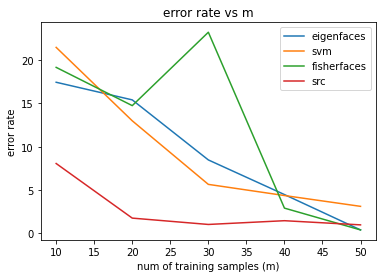

In [ ]:

plt.plot(m_set,score_m_eigen,label = f"eigenfaces")
plt.plot(m_set,score_m_svm,label = f"svm")
plt.plot(m_set,score_m_lda,label = f"fisherfaces")
plt.plot(m_set,score_m_src,label = f"src")
plt.title(f"error rate vs m")
plt.xlabel("num of training samples (m)")
plt.ylabel("error rate")
plt.legend()